In [14]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from sklearn.metrics import mean_squared_error
from dataset import Dataset
from torchvision import transforms

In [15]:
def evaluate_model(model, dataloader, device):
    model.eval()  # Set the model to evaluation mode
    total_loss = 0.0
    all_predictions = []
    all_ground_truths = []

    with torch.no_grad():
        for inputs, _, landmarks in dataloader:
            inputs = inputs.permute(0, 3, 1, 2).float().to(device)
            landmarks = landmarks.float().to(device)

            outputs = model(inputs)
            loss = nn.MSELoss()(outputs, landmarks)

            total_loss += loss.item() * inputs.size(0)
            all_predictions.append(outputs.cpu().numpy())
            all_ground_truths.append(landmarks.cpu().numpy())
    
    avg_loss = total_loss / len(dataloader.dataset)
    all_predictions = np.concatenate(all_predictions, axis=0)
    all_ground_truths = np.concatenate(all_ground_truths, axis=0)
    
    # Compute other metrics
    mse = mean_squared_error(all_ground_truths.reshape(-1, 2), all_predictions.reshape(-1, 2))
    
    print(f'Average Loss: {avg_loss:.4f}')
    print(f'Mean Squared Error (MSE): {mse:.4f}')
    
    return avg_loss, mse

In [16]:
def visualize_predictions(model, dataloader, device, num_samples=5):
    model.eval()
    with torch.no_grad():
        for i, (inputs, _, landmarks) in enumerate(dataloader):
            if i >= num_samples:
                break
            
            inputs = inputs.permute(0, 3, 1, 2).float().to(device)
            landmarks = landmarks.float().to(device)
            outputs = model(inputs).cpu().numpy()
            
            for j in range(inputs.size(0)):
                img = inputs[j].cpu().numpy().transpose(1, 2, 0)  # Convert back to HWC
                true_landmarks = landmarks[j].cpu().numpy()
                pred_landmarks = outputs[j]

                plt.figure(figsize=(12, 6))
                plt.subplot(1, 2, 1)
                plt.imshow(img)
                plt.scatter(true_landmarks[:, 0], true_landmarks[:, 1], color='g', marker='x')
                plt.title('Ground Truth')

                plt.subplot(1, 2, 2)
                plt.imshow(img)
                plt.scatter(pred_landmarks[:, 0], pred_landmarks[:, 1], color='r', marker='o')
                plt.title('Predictions')

                plt.show()

In [17]:
class LandmarkModel(nn.Module):
    def __init__(self, input_channels=3, num_landmarks=68):
        super(LandmarkModel, self).__init__()
        self.conv1 = nn.Conv2d(input_channels, 64, kernel_size=3, stride=1, padding=1)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1)
        self.pool = nn.AdaptiveAvgPool2d((1, 1))  # Adaptive pooling to handle variable sizes
        self.fc1 = nn.Linear(128, 1000)
        self.fc2 = nn.Linear(1000, num_landmarks * 2)  # Output landmarks

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2)
        x = self.pool(x)  # Adaptive pooling
        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x.view(-1, 68, 2).float()  # Reshape to [batch_size, 68, 2]

In [18]:
validation_dataset = Dataset(root_dir='archive/ibug_300W_large_face_landmark_dataset/afw')
validation_dataloader = DataLoader(validation_dataset, batch_size=8, shuffle=False, num_workers=4)

In [24]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LandmarkModel().to(device)

# Load the trained model
model.load_state_dict(torch.load('model/landmark_model.pth'))
model.eval()

# Evaluate the model
evaluate_model(model, validation_dataloader, device)

# Visualize predictions
#visualize_predictions(model, validation_dataloader, device)

<ipython-input-24-b2e6f563278d>:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model/landmark_model.pth'))


Average Loss: 2128.9030
Mean Squared Error (MSE): 2128.8970


(2128.9029580860533, 2128.897)

In [40]:
def visualize_single_image_prediction(model, image, landmarks, device):
    model.eval()
    with torch.no_grad():
        # Preprocess the image
        image_tensor = transforms.ToTensor()(image).unsqueeze(0).to(device)  # Add batch dimension
        
        # Predict landmarks
        predicted_landmarks = model(image_tensor).cpu().numpy().reshape(-1, 2)  # Remove batch dimension
        
        # Debugging: Print shapes
        print("Predicted landmarks shape:", predicted_landmarks.shape)
        print("Ground truth landmarks shape:", landmarks.shape)
        

        # Convert image tensor to numpy array
        image_np = image_tensor.squeeze(0).cpu().numpy().transpose(1, 2, 0)  # Remove batch dimension and transpose

        # Plot the image
        plt.figure(figsize=(8, 8))
        plt.imshow(image_np)
        plt.scatter(landmarks[:, 0], landmarks[:, 1], color='g', marker='x', label='Ground Truth')
        
        # Check if predicted_landmarks is 2D
        if predicted_landmarks.ndim == 2 and predicted_landmarks.shape[1] == 2:
            plt.scatter(predicted_landmarks[:, 0], predicted_landmarks[:, 1], color='r', marker='o', label='Predictions')
        else:
            raise ValueError("Predicted landmarks are not in the expected format.")
        
        plt.legend()
        plt.title('Model Prediction vs Ground Truth')
        plt.show()

Predicted landmarks shape: (68, 2)
Ground truth landmarks shape: (68, 2)


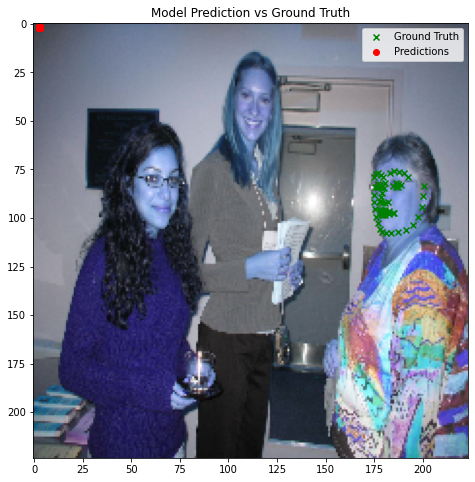

In [41]:
sample_idx = 3
image, _, landmarks = validation_dataset.__getitem__(sample_idx)

visualize_single_image_prediction(model, image, landmarks, device)